## Solution representation tools
This notebook contains tools for mapping state_coeffs (coefficients to the piecewise polynomial numerical solution at the DG nodes saved in `solver.elem_helpers.x_elems`) to 1) the polynomial representation, 2) the partial derivative d/dt of the conserved quantities, (and dependent quantities such as the drag term through the chain rule), and 3) a functional that accepts a (Green's) function as input and returns the integral of (f g dx).

To use, specify location of quail source code, the location of .pkl files to read, and the naming scheme of the .pkl files in `filename_template`.

In [15]:
# Specify quail source directory
source_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src"
# Specify data directory (where the .pkl files are)
target_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\scenarios\free"
# Specify pkl filename template
filename_template = lambda domain_idx, time_idx: \
  f"conduit_sub{domain_idx}_{time_idx}.pkl"

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.interpolate

In [17]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

### 1. Piecewise polynomial representation

This section contains functions that evaluate or plot the piecewise polynomial solution.

Note that evaluating derivatives of the numerical solution is not straightforward. While the intraelement derivative can be used in smooth parts of the solution, the discontinuity of the solution implies that the weak derivative may not even be a bounded function. That is, for a function f, taking f' as the pointwise derivative within each element, we don't have
```
    integral f' = f(b) - f(a)
```
because of jumps between elements. In fact,
```
    integral f' = f(b) - f(a) + sum([[f]]),
```
where [[ f ]] is the jump in f across each element boundary.

Integrating the numerical solution is fine.

In [18]:
solver_from = lambda i, j: readwritedatafiles.read_data_file(
  filename_template(i,j))

In [46]:
def elt_index(x_in:float, node_coords):
  ''' Maps location to element index. '''
  if x_in <= node_coords[0]:
    return 0
  if x_in >= node_coords[-1]:
    return node_coords.shape[0]-2
  return node_coords.shape[0] \
    - np.argmax((x_in >= node_coords)[::-1]) - 1

def eval_soln(x, x_elems, proj_vals, node_coords):
  ''' Evaluates piecewise polynomial solution. At element faces, returns value
   from the left element. '''
  # Wrap x in array if scalar
  x = np.asarray(x)
  y = np.empty_like(x)
  # Piecewise evaluation
  for i, _x in enumerate(x.ravel()):
    # JIT interpolation construction from scipy lagrange interp interface
    _elt_idx = elt_index(_x, node_coords)
    _poly = scipy.interpolate.lagrange(
      x_elems[_elt_idx,:,0].ravel(),
      proj_vals[_elt_idx,:,0])
    y.ravel()[i] = _poly(_x)
  return y

def plot_DGsoln(x_elems, vals, node_coords):
  ''' Plots piecewise polynomial solution. Uses a built-in x-axis. '''
  # Define colors of polynomial in each element; loops around
  colorcycle = ["red", "black"]
  for elt_idx in range(x_elems.shape[0]):
    # Define points in current element to plot at
    x_loc = np.linspace(node_coords[elt_idx], node_coords[elt_idx+1], 5)
    # Define the local polynomial representation of vals
    _poly = scipy.interpolate.lagrange(
      x_elems[elt_idx,:,0].ravel(),
      vals[elt_idx,:,0])
    # Add plotz
    plt.plot(x_loc, _poly(x_loc), '-',
             color=colorcycle[elt_idx % len(colorcycle)])

In [42]:
# Load solver
solver = solver_from(3, 15500)
# Evaluate mixture density on a test range
x_sample = np.linspace(-700,-550,100)
rho = eval_soln(x_sample,
                solver.elem_helpers.x_elems,
                solver_from(3, 15500).state_coeffs[...,0:3].sum(axis=-1, keepdims=True),
                solver_from(3, 15500).mesh.node_coords)

Piecewise polynomial representation in DG. Second plot is a zoom-in of the first, showing the parabolic pieces that can have jumps between elements.


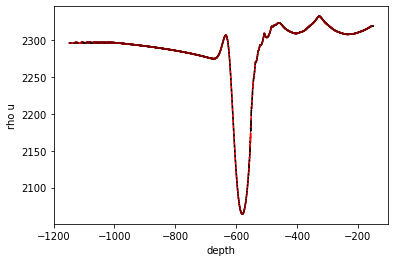

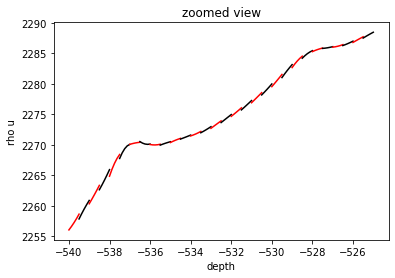

In [141]:
# Join solver nodes and values
U = np.concatenate([solver_from(i, 15500).state_coeffs for i in range(5)], axis=0)
x_elems = np.concatenate([solver_from(i, 15500).elem_helpers.x_elems for i in range(5)], axis=0)
node_coords = np.concatenate([solver_from(i, 15500).mesh.node_coords[:-1,...]
                              for i in range(5)] +
                                [solver_from(4, 15500).mesh.node_coords[-1:,...]],
                              axis=0)
# Show momentum
plt.figure(1)
plot_DGsoln(x_elems, U[...,3:4], node_coords)
plt.ylabel("rho u")
plt.xlabel("depth")
plt.figure(2)
plot_DGsoln(x_elems[1220:1250,...], U[1220:1250,...,3:4], node_coords[1220:1250+1,...])
plt.ylabel("rho u")
plt.xlabel("depth")
plt.title("zoomed view")
print("Piecewise polynomial representation in DG. Second plot is a zoom-in of "+
      "the first, showing the parabolic pieces that can have jumps between elements.")

### 2. Evaluating d/dt using the PDE RHS

In this section we evaluate the time-derivative of drag locally. Only one time index is needed, since the time-derivative of drag is expanded using the chain rule. Let U be the vector of conservative variables. Then
```
d/dt(drag) = d/dU(drag) dU/dt
```
and since dU/dt is the left-hand-side of the PDE, we can replace dU/dt by the right-hand-side, which depends on U.

In [86]:
def drag_sgrad_estimate(solver, eval_at_quad_points:bool=False) -> np.array:
  ''' Numerical estimate of gradient of drag with respect to state variables.
  Computes drag at solver.state_coeffs + dU and solver.state_coeffs - dU
  and takes the finite difference approximation. Output is evaluated at the
  nodal points.

  Inputs:
    solver
    eval_at_quad_points: if True, evaluates at quadrature points; else, at nodes
  Returns:
    sgrad as an np.array of shape (num_elems, num_basis, 1, num_states).'''
  
  # Step size for numerical gradient computation
  h_unscaled = 1e-7
  # Fixed scaling for each state coefficient (size == number of states)
  scale = np.array([1e-6, 1, 1, 1, 1e8, 1, 1, 1])
  if eval_at_quad_points:
    U = np.einsum("ij, ljk -> lik",
      solver.elem_helpers.basis_val,
      solver.state_coeffs)
  else:
    U = solver.state_coeffs
  # Allocate
  dU = np.empty_like(U)
  sjac = np.zeros((*U.shape[:2], 1, len(scale)))
  # Compute central difference for each state variable
  for i in range(U.shape[-1]):
    dU[:] = 0
    h = h_unscaled * scale[i]
    dU[...,i] = h
    drag_plus = solver.physics.compute_additional_variable("Drag",
      U + dU, False)
    drag_minus = solver.physics.compute_additional_variable("Drag",
      U - dU, False)
    sjac[...,i] = (drag_plus - drag_minus)/(2*h)
  return sjac

In [87]:
def ddt_conservative_vars(solver, eval_at_quad_points:bool=False) -> np.array:
  '''Compute d/dt of the conservative field variables. Extrapolates at boundary
  from the closest interior element, since the boundary residual is not
  available once disconnected from the multidomain (parallel) setup.
  
  Inputs:
    solver
    eval_at_quad_points: if True, evaluates at quadrature points; else, at nodes
  Returns:
    dU/dt as an np.array of shape (num_elems, num_basis, num_states).'''
  # Allocate
  U = solver.state_coeffs.copy()
  res = np.zeros_like(U)
  # Get residual without boundary_face_residuals
  solver.get_element_residuals(U, res)
  solver.get_interior_face_residuals(U, res)
  # Extrapolate residual to boundary-adjacent elements
  res[0] = res[1]
  res[-1] = res[-2]
  # Apply inverse mass matrix to obtain change in field variable at nodes
  dUdt = solver_tools.mult_inv_mass_matrix(solver.mesh, solver,
    solver.stepper.dt, res)/solver.stepper.dt
  if eval_at_quad_points:
    # Chain rule to compute dUdt at quadrature points
    dUdt = np.einsum("ij, ljk -> lik",
      solver.elem_helpers.basis_val,
      dUdt)
  return dUdt

Text(0, 0.5, 'd(drag)/dt')

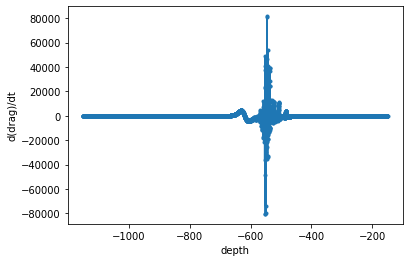

In [88]:
# Compute d(drag)/dU for each segment of domain
sgrad = np.concatenate([drag_sgrad_estimate(solver_from(i,15500)) for i in range(5)], axis=0)
dUdt = np.concatenate([ddt_conservative_vars(solver_from(i,15500)) for i in range(5)], axis=0)
# Evaluate d(drag)/dt by chain rule: d(drag)/dU * dU/dt for each element, node
ddt_drag = np.einsum("ijkl, ijl -> ijk", sgrad, dUdt)
# Plot drag pointwise
plt.plot(x_elems.ravel(), ddt_drag.ravel(), '.-')
plt.xlabel("depth")
plt.ylabel("d(drag)/dt")

### 3. Spatial integration of the signal

To see the effect of numerical quadrature of a noisy signal for d/dt(tau), here we compare Gauss integration of d/dt(tau) computed as above to one-point approximation. For each element, we approximate the spatial integral as the nodal value at index 0 (the left node), the nodal value at index 1 (the center node), and the Gauss quadrature (uses all nodes).

Gauss quadrature has less amplification of the numerical oscillations, but does not seem to be the cause of the oscillations. Taking the algebraic mean of the nodal values seems to be a quick and easy improvement, though unlike Gauss quadrature it is not motivated by the theory.

In [117]:
def gauss_integ(solver, G:callable) -> np.array:
  ''' Elementwise classical Gauss quadrature against a function G. Evaluates
    int (d/dt(drag) * G) dx on each element.
    
  Inputs:
    solver
    G: vectorized function to integrate against
  Returns:
    1-D array of local integrals (d/dt(drag) * G) on each element. This can be
    summed to obtain the total integral. '''
  
  # Evaluate d/dt(drag) at quadrature points
  ddt_drag = np.einsum("ijkl, ijl -> ijk",
                       drag_sgrad_estimate(solver, eval_at_quad_points=True),
                       ddt_conservative_vars(solver, eval_at_quad_points=True))
  # Evaluate G at quadrature points
  elem_centers = 0.5 * (solver.mesh.node_coords[1:,:] + solver.mesh.node_coords[:-1,:])
  x_quad = elem_centers + (solver.elem_helpers.quad_pts[...,0] / 2
                          * solver.elem_helpers.jac_elems[...,0,0])
  G_quad = G(x_quad)
  return np.einsum("ijk, ij, ij, j -> i",
      ddt_drag,
      G_quad,
      solver.elem_helpers.jac_elems[:,:,0,0],
      solver.elem_helpers.quad_wts[:,0])

Locally integrated d/dt(tau)


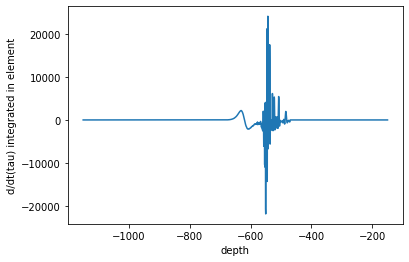

In [133]:
# Example: integrate locally against G(x) = 1 
G = lambda x: np.ones_like(x)
# Compute d/dt(drag) integrated on each element
loc_integrated_ddt_drag = np.concatenate([gauss_integ(solver_from(i,15500), G)
                                          for i in range(5)], axis=0)
# Get node points
x_elems = np.concatenate([solver_from(i, 15500).elem_helpers.x_elems
                          for i in range(5)], axis=0)
# Get center of element
x_center = x_elems.mean(axis=1)
plt.plot(x_center, loc_integrated_ddt_drag)
plt.ylabel("d/dt(tau) integrated in element")
plt.xlabel("depth")
print("Locally integrated d/dt(tau).")

One-point approximation to integral using node 0 (left node), node 1 (center node), and Gauss quadrature.
In a separate plot, Gauss quadrature and algebraic mean.


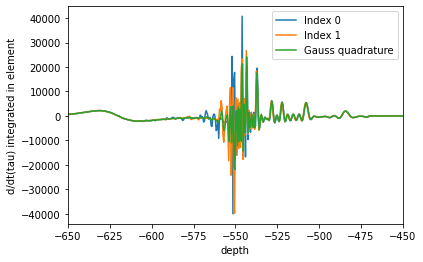

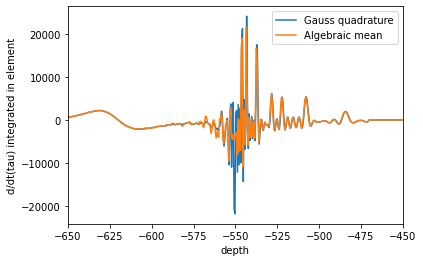

In [140]:
# Compare to one-point approximation of integral
dx = node_coords[1,0] - node_coords[0,0]
plt.plot(x_elems[:,0,:], ddt_drag[:,0,:] * dx)
plt.plot(x_elems[:,0,:], ddt_drag[:,1,:] * dx)
plt.plot(x_center, loc_integrated_ddt_drag)

plt.xlabel("depth")
plt.ylabel("d/dt(tau) integrated in element")
plt.xlim(-650, -450)
plt.legend(["Index 0", "Index 1", "Gauss quadrature"])

plt.figure()
plt.plot(x_center, loc_integrated_ddt_drag)
plt.plot(x_elems[:,0,:], ddt_drag[:,:,:].mean(axis=1) * dx)
plt.xlabel("depth")
plt.ylabel("d/dt(tau) integrated in element")
plt.xlim(-650, -450)
plt.legend(["Gauss quadrature", "Algebraic mean"])

print("One-point approximation to integral using node 0 (left node), node 1 (center node), and Gauss quadrature.")
print("In a separate plot, Gauss quadrature and algebraic mean.")
